
# Reconhecimento de dígitos manuscritos

Este exemplo demonstra como Redes Neurais podem ser usadas para reconhecer imagens de dígitos manuscritos, de 0 a 9.


In [1]:
# Importações padrão do Python científico
import matplotlib.pyplot as plt
import numpy as np

# Importar conjuntos de dados, classificadores e métricas de desempenho
from sklearn import datasets, metrics
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

# Importar biblioteca para aquisitar tempo
import time  

# Importa biblioteca de manipulação de Redes Neurais
import torch
import torch.nn as nn
import torch.optim as optim


## Conjunto de dados de Dígitos

O conjunto de dados de dígitos consiste em imagens de dígitos de 8x8
pixels. O atributo "images" do conjunto de dados armazena
matrizes de 8x8 com valores de escala de cinza para cada imagem. Usaremos essas matrizes para
visualizar as 4 primeiras imagens. O atributo "target" do conjunto de dados armazena
o dígito que cada imagem representa, e isso está incluído no título das 4
gráficos abaixo.

Observação: se estivéssemos trabalhando com arquivos de imagem (por exemplo, arquivos 'png'), os carregaríamos usando a função `matplotlib.pyplot.imread`.

Abaixo, visualizamos as 4 primeiras amostras de teste e mostramos seu valor de dígito previsto no título.



1. **Conjunto de Dados `digits`:**
   - É um dataset do Scikit-learn com imagens de dígitos manuscritos (0 a 9).
   - `digits.images`: Contém as imagens dos dígitos (matrizes 8x8 de intensidades de pixel).
   - `digits.target`: Contém os rótulos (números de 0 a 9) correspondentes a cada imagem.

2. **`plt.subplots`:**
   - Cria uma grade de subplots para visualizar várias imagens lado a lado.
   - `nrows=1, ncols=4`: Uma linha e quatro colunas.

3. **`ax.imshow`:**
   - Plota cada imagem em um subplot, utilizando escala de cinza (`cmap=plt.cm.gray_r`) para facilitar a visualização.

4. **`set_title`:**
   - Adiciona o rótulo do dígito ao título de cada subplot para identificar qual número é representado.


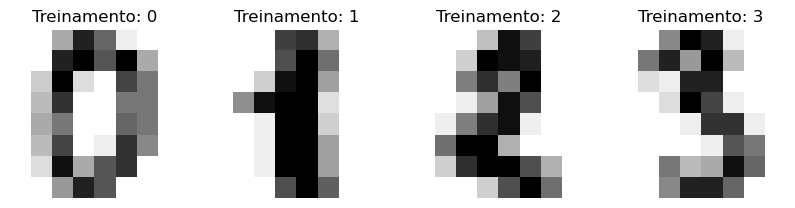

In [2]:
# Carrega o conjunto de dados "digits" (dígitos manuscritos) do sklearn
digits = datasets.load_digits()

# Cria uma figura com 1 linha e 4 colunas de gráficos, definindo o tamanho total da figura
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))

# Itera sobre os eixos (subplots), as imagens dos dígitos e seus rótulos
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()  # Remove os eixos para uma visualização mais limpa
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")  
    # Mostra a imagem do dígito em escala de cinza, com interpolação "nearest"
    ax.set_title("Treinamento: %i" % label)  
    # Define o título do subplot indicando o rótulo do dígito

# Definição do dispositivo

In [3]:
# Verifica se temos gpu disponível e se ela é ccompatível

if torch.cuda.is_available():
    device = torch.device("cuda")

else: 
    device = torch.device("cpu")
    
print(device)


cpu


# Alocando memória

1. **Achatar as Imagens:**
   - As imagens no dataset são originalmente matrizes 8x8.
   - A transformação "achatada" converte cada matriz em um vetor de 64 elementos (uma linha única).

2. **Divisão dos Dados:**
   - `train_test_split` divide os dados em conjuntos de treino e teste.
   - **Treino:** Dados usados para ajustar o modelo (30% das amostras).
   - **Teste:** Dados usados para validar o desempenho do modelo (70% das amostras).

3. **Conversão para Tensores:**
   - Os tensores do PyTorch são usados para cálculos em frameworks de aprendizado profundo.
   - `requires_grad=True` habilita o cálculo automático de gradientes para aprendizado.
   - `.to(device)` permite usar GPU, se disponível, para acelerar os cálculos.

4. **Redimensionamento dos Rótulos:**
   - Os rótulos (`y_treino` e `y_teste`) são redimensionados para formar vetores coluna, necessários em muitas operações de aprendizado profundo.

In [4]:
# Achatar as imagens
n_amostras = len(digits.images)  
# Obtém o número total de amostras (imagens) no conjunto de dados

dados = digits.images.reshape((n_amostras, -1))  
# Redimensiona cada imagem (8x8) para um vetor unidimensional de 64 elementos
# Cada linha de "dados" agora representa uma imagem achatada

# Dividir os dados em 70% para teste e 30% para treinamento
X_treino, X_teste, y_treino, y_teste = train_test_split(
    dados, digits.target, test_size=0.7, shuffle=False  
    # `test_size=0.7` significa que 70% dos dados serão usados como teste
    # `shuffle=False` mantém a ordem original dos dados ao dividir
)

# Converter os dados de entrada de treino em tensores do PyTorch
x_treino_tc = torch.tensor(X_treino, dtype=torch.float32, requires_grad=True).to(device)
# Cria um tensor de números de ponto flutuante a partir dos dados de entrada do treino (X_treino)
# `requires_grad=True` permite calcular gradientes para aprendizado
# `.to(device)` transfere o tensor para o dispositivo especificado (CPU ou GPU)

# Converter os dados de entrada de teste em tensores do PyTorch
x_teste_tc = torch.tensor(X_teste, dtype=torch.float32, requires_grad=True).to(device)

# Converter os rótulos de treino em tensores do PyTorch
y_treino_tc = torch.tensor(y_treino, dtype=torch.float32, requires_grad=True).reshape(-1, 1).to(device)
# Converte os rótulos de treino para tensores e os redimensiona para um formato de vetor coluna (-1, 1)

# Converter os rótulos de teste em tensores do PyTorch
y_teste_tc = torch.tensor(y_teste, dtype=torch.float32, requires_grad=True).reshape(-1, 1).to(device)


# Definição da rede

1. **Camadas de Entrada e Saída:**
   - A camada de entrada recebe dados com dimensão igual ao número de características das amostras.
   - A camada de saída tem 1 neurônio, geralmente usado em tarefas como regressão ou classificação binária.

2. **Camadas Escondidas:**
   - Contêm 4 neurônios e aplicam funções de ativação (ReLU e Sigmoid) para introduzir não-linearidade.

3. **Função `nn.Sequential`:**
   - Agrupa as camadas em uma estrutura sequencial, onde a saída de uma camada serve como entrada para a próxima.


In [5]:
modules = []  
# Cria uma lista vazia para armazenar as camadas da rede neural

# Camada de entrada
modules.append(nn.Linear(x_treino_tc.shape[1], 4))  
# Adiciona uma camada linear (totalmente conectada) que mapeia os dados de entrada
# O número de neurônios na entrada é igual ao número de características das amostras (`x_treino_tc.shape[1]`)
# A camada de saída da entrada tem 4 neurônios

# Camadas escondidas
modules.append(nn.Linear(int(4), int(4)))  
# Adiciona uma camada escondida com 4 neurônios na entrada e na saída

modules.append(nn.ReLU())  
# Adiciona a função de ativação ReLU (Rectified Linear Unit), que introduz não-linearidade

modules.append(nn.Linear(int(4), int(4)))  
# Adiciona outra camada escondida com 4 neurônios na entrada e na saída

modules.append(nn.Sigmoid())  
# Adiciona a função de ativação Sigmoid, que restringe os valores de saída para o intervalo [0, 1]

# Camada de saída
modules.append(nn.Linear(4, 1))  
modules.append(nn.Hardtanh(min_val=0, max_val=9))  
# Adiciona a camada de saída com 4 neurônios na entrada e 1 neurônio na saída
# Geralmente usada para tarefas de regressão ou classificação binária

# Combina todas as camadas em uma rede neural sequencial
neural_net = nn.Sequential(*modules)  

# `nn.Sequential` cria uma rede neural onde as camadas são aplicadas sequencialmente

# Exibe a estrutura da rede neural
print(neural_net)


Sequential(
  (0): Linear(in_features=64, out_features=4, bias=True)
  (1): Linear(in_features=4, out_features=4, bias=True)
  (2): ReLU()
  (3): Linear(in_features=4, out_features=4, bias=True)
  (4): Sigmoid()
  (5): Linear(in_features=4, out_features=1, bias=True)
  (6): Hardtanh(min_val=0, max_val=9)
)


# Treino


1. **Épocas e Batches**:
   - O número de épocas (`n_epochs`) define quantas vezes o modelo vai passar por todo o conjunto de dados.
   - O treinamento é feito em **batches**, ou lotes, para evitar o processamento de todas as amostras de uma vez, o que poderia ser ineficiente, especialmente com grandes volumes de dados. O tamanho do lote é definido por `batch_size`.

2. **Função de Perda (Loss Function)**:
   - **MSELoss** é uma função comum para tarefas de **regressão**. Ela calcula o erro quadrático médio entre os valores previstos e os valores reais.
   
3. **Otimizador Adam**:
   - O **Adam** é um otimizador eficiente, amplamente utilizado em redes neurais. Ele ajusta os parâmetros da rede neural para reduzir a perda com base no cálculo dos gradientes.
   - A taxa de aprendizado (`lr=0.001`) controla o tamanho dos ajustes feitos nos parâmetros durante o treinamento.

4. **Retropropagação (Backpropagation)**:
   - A retropropagação (`data_loss.backward()`) é uma técnica usada para calcular os gradientes dos parâmetros da rede neural em relação à função de perda.
   - `optimizer.step()` aplica as atualizações nos parâmetros da rede com base nesses gradientes.

5. **Monitoramento do Treinamento**:
   - O código imprime a perda a cada 100 épocas para ajudar a monitorar o progresso do treinamento e entender se a rede está melhorando.
   
6. **Armazenamento da Perda**:
   - `data_loss_it` armazena a perda de cada época, permitindo que você observe como o erro evolui ao longo do treinamento. Isso pode ser útil para visualizar o progresso e verificar se o modelo está convergindo.

Esse código implementa o treinamento básico de uma rede neural com backpropagation, otimizada com o algoritmo Adam, para uma tarefa de regressão.

In [6]:
n_epochs = 500  
# Define o número de épocas (iterações) para o treinamento da rede neural.

batch_size = 100  
# Define o tamanho do lote (quantidade de amostras que serão processadas em cada iteração do treinamento).

loss_fn = nn.MSELoss()  
# Define a função de perda como erro quadrático médio (MSE - Mean Squared Error).
# A MSE é comumente usada em tarefas de regressão, pois mede a diferença entre os valores previstos e reais.

optimizer = optim.Adam(neural_net.parameters(), lr=0.001)  
# Define o otimizador como Adam, que é eficiente para redes neurais.
# Ele ajusta os parâmetros da rede neural para minimizar a função de perda.
# A taxa de aprendizado (lr) é definida como 0.001, o que controla o quão rápido os parâmetros são atualizados.

data_loss_it = torch.zeros(n_epochs).to(device)  
# Cria um tensor com zeros para armazenar os valores de perda (loss) em cada época do treinamento.
# O tensor é movido para o dispositivo (CPU ou GPU), dependendo da configuração.

# Loop de treinamento por época
for epoch in range(n_epochs):  
    # Itera por cada época de treinamento (total de n_epochs)

    for i in range(0, len(x_treino_tc), batch_size):  
        # Itera sobre os dados de treinamento em lotes de tamanho `batch_size`
        # Isso divide os dados em partes menores para processá-los de forma mais eficiente.

        x_batch = x_treino_tc[i : i + batch_size]  
        # Extrai o lote de dados de entrada (`x_batch`) para o treinamento.
        y_batch = y_treino_tc[i : i + batch_size]  
        # Extrai o lote de rótulos (`y_batch`) correspondentes aos dados de entrada.

        nn_pred = neural_net(x_batch)  
        # Faz a previsão da rede neural para o lote de dados de entrada.

        data_loss = loss_fn(y_batch, nn_pred)  
        # Calcula a perda (erro) entre os rótulos reais (`y_batch`) e as previsões feitas pela rede (`nn_pred`).

        # Limpa os gradientes acumulados da iteração anterior
        optimizer.zero_grad()  

        # Realiza a retropropagação para calcular os gradientes
        data_loss.backward()  

        # Atualiza os parâmetros da rede neural com base nos gradientes calculados
        optimizer.step()  

    # Armazena o valor da perda da época atual no vetor `data_loss_it`
    data_loss_it[epoch] = data_loss.item()  

    # Exibe a perda a cada 100 épocas ou na primeira época
    if ((epoch + 1) % 100) == 0 or epoch == 0:  
        # A cada 100 épocas ou na primeira época, imprime o número da época e o valor da perda
        print(f"Finished epoch {epoch+1}, latest loss {data_loss}")

Finished epoch 1, latest loss 30.249013900756836
Finished epoch 100, latest loss 13.874252319335938
Finished epoch 200, latest loss 10.160490036010742
Finished epoch 300, latest loss 9.479463577270508
Finished epoch 400, latest loss 9.389582633972168
Finished epoch 500, latest loss 9.381266593933105


1. **Conversão dos Dados de Perda**:
   - O vetor `data_loss_it`, que contém os valores de perda de cada época, é movido para a CPU (caso esteja em uma GPU) e convertido para um array `numpy`, que é mais fácil de manipular para gráficos.

2. **Configuração da Figura e Eixo**:
   - A função `plt.figure()` cria uma nova figura com um tamanho de 12x6 polegadas.
   - O título da figura é definido com `suptitle()`, e a fonte do título é configurada para 16.

3. **Plotagem do Gráfico**:
   - O gráfico é criado usando `plot()`, onde o eixo X representa as iterações (épocas) e o eixo Y mostra o valor da perda para cada época.
   - A linha `ax.set_xlabel("iterações")` e `ax.set_ylabel("perda")` define os rótulos dos eixos para ajudar a interpretar o gráfico.

4. **Legendas e Grade**:
   - `ax.grid()` ativa uma grade no gráfico para melhorar a leitura dos valores.
   - `ax.legend()` exibe a legenda no gráfico, que é definida pela string fornecida em `label="Data loss"`, permitindo identificar a linha do gráfico.

5. **Exibição do Gráfico**:
   - A função `plt.show()` exibe o gráfico gerado, permitindo visualizar como a perda do modelo evolui ao longo das épocas de treinamento.


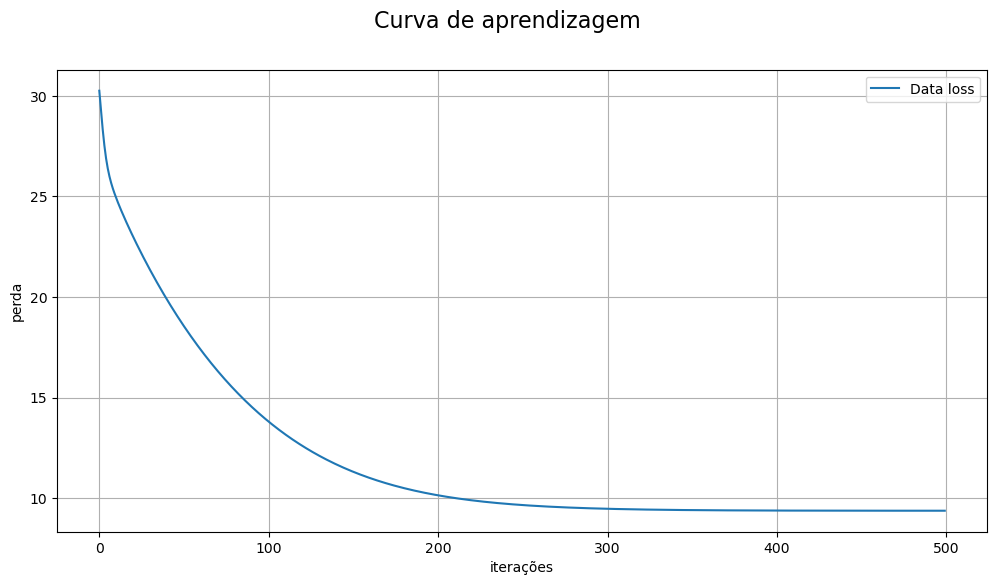

In [7]:
loss_it = data_loss_it.cpu().numpy()  
# Converte os dados de perda `data_loss_it` que estão armazenados no dispositivo (GPU ou CPU) para um formato numpy.
# A função `cpu()` garante que os dados sejam movidos para a CPU antes da conversão.

fig = plt.figure(figsize=[12, 6])  
# Cria uma nova figura para o gráfico com o tamanho especificado (12x6 polegadas).

fig.suptitle("Curva de aprendizagem", fontsize=16)  
# Define o título da figura ("Curva de aprendizagem") e o tamanho da fonte (16).

# Plotando gráfico 3D
ax = fig.add_subplot(1, 1, 1)  
# Cria um único eixo (subplot) dentro da figura. Como há apenas 1 gráfico, as dimensões são 1 linha e 1 coluna.

ax.set_xlabel("iterações")  
# Define o rótulo do eixo X como "iterações" (refere-se ao número de épocas ou iterações de treinamento).

ax.set_ylabel("perda")  
# Define o rótulo do eixo Y como "perda" (refere-se ao valor da função de perda).

ax.plot(
    range(len(loss_it)),  
    loss_it,  
    label="Data loss",  
    # Plota os valores da perda ao longo das iterações, com o eixo X representando as iterações (épocas) e o eixo Y a perda.
    # `loss_it` contém os valores de perda armazenados durante o treinamento.
    # O argumento `label="Data loss"` serve para dar um nome à linha no gráfico.
)

ax.grid()  
# Adiciona uma grade ao gráfico para facilitar a leitura dos valores.

ax.legend()  
# Exibe a legenda no gráfico, utilizando o rótulo fornecido (`label="Data loss"`).

plt.show()  
# Exibe o gráfico gerado.


# Validação

In [8]:
# Computando previsão para o conjunto de teste
with torch.no_grad():
    test_pred = torch.round(neural_net(x_teste_tc))

A função `sklearn.metrics.classification_report` cria um relatório de texto mostrando
as principais métricas de classificação.

In [9]:
# Avaliando métricas de classificação
previsto = test_pred.cpu().numpy()

print(
    f"Relatório de classificação para o classificador:\n"
    f"{metrics.classification_report(y_teste, previsto)}\n"
)


Relatório de classificação para o classificador:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       123
           1       0.00      0.00      0.00       127
           2       0.00      0.00      0.00       122
           3       0.00      0.00      0.00       128
           4       0.10      1.00      0.18       128
           5       0.00      0.00      0.00       128
           6       0.00      0.00      0.00       128
           7       0.00      0.00      0.00       126
           8       0.00      0.00      0.00       121
           9       0.00      0.00      0.00       127

    accuracy                           0.10      1258
   macro avg       0.01      0.10      0.02      1258
weighted avg       0.01      0.10      0.02      1258




/home/thiago-esterci/anaconda3/envs/mlWorkshop/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/thiago-esterci/anaconda3/envs/mlWorkshop/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/thiago-esterci/anaconda3/envs/mlWorkshop/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

Também podemos plotar uma `matriz de confusão` dos
valores reais e dos valores de dígito previstos.

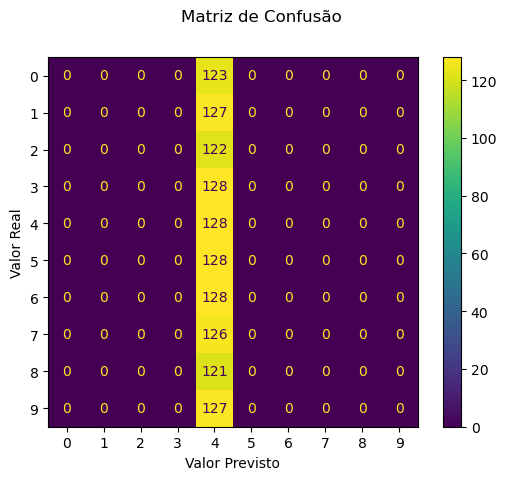

In [10]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_teste, previsto)  
# Cria a matriz de confusão usando a função `from_predictions` da classe `ConfusionMatrixDisplay` do módulo `metrics` do Scikit-learn.
# Essa função recebe os valores reais (`y_teste`) e os valores previstos (`previsto`) para calcular e exibir a matriz de confusão.

disp.figure_.suptitle("Matriz de Confusão")  
# Define o título da figura gerada para a matriz de confusão. Aqui, o título é "Matriz de Confusão".

plt.xlabel("Valor Previsto")  
# Define o rótulo do eixo X como "Valor Previsto", representando os rótulos que foram previstos pelo modelo.

plt.ylabel("Valor Real")  
# Define o rótulo do eixo Y como "Valor Real", representando os rótulos verdadeiros dos dados de teste.

plt.show()  
# Exibe o gráfico gerado, mostrando a matriz de confusão com os rótulos dos eixos e o título definidos acima.


## Grid-search

Dada a complexidade dos modelos, nem sempre os hiperparâmetros escolhidos vão resultar na melhor performance do modelo. Portanto, para adaptar o modelo a base de dados estudada é necessário testar combinações diferentes com o intuito de alcançar o melhor resultado possível. Vale ressaltar que a busca de hiperparâmetros é um problema de otimização e pode ser resolvido com outras técnicas como os `algoritmos genéticos`.


1. **Arquiteturas de Rede Neural**:
   - A lista `hidden_layer_sizes` contém diferentes configurações de número de neurônios nas camadas ocultas. O código treina e testa diferentes configurações para encontrar a melhor arquitetura de rede neural.
   
2. **Definição da Rede Neural**:
   - A rede é construída dinamicamente com base na arquitetura `hd` especificada em cada iteração do loop. As camadas incluem:
     - **Camada de entrada**: Recebe os dados de entrada com o número de características especificado.
     - **Camadas ocultas**: São formadas conforme os valores na lista `hd`. Cada camada oculta é seguida de uma função de ativação ReLU.
     - **Camada de saída**: A camada final possui um único neurônio, seguida por uma função de ativação `Hardtanh` para limitar a saída.
   
3. **Treinamento da Rede Neural**:
   - A rede neural é treinada usando a função de perda MSE (erro quadrático médio) e o otimizador Adam.
   - O treinamento é realizado em lotes (tamanho de `batch_size`) e as atualizações de pesos são feitas após o cálculo dos gradientes.

4. **Teste e Avaliação**:
   - Após o treinamento, o modelo é testado no conjunto de teste (`x_teste_tc`) e a acurácia do modelo é calculada usando `accuracy_score`.
   - O modelo com a maior acurácia é mantido como o melhor modelo?


In [11]:
# Este é um dicionário que especifica os hiperparâmetros a serem ajustados durante a busca em grade
hidden_layer_sizes = [
    [64],
    [64, 64],
    [128],
    [128, 128],
    [256],
    [256, 256],
]
# A variável `hidden_layer_sizes` contém diferentes configurações para o número de neurônios nas camadas ocultas da rede neural.
# Cada elemento da lista é uma lista que define a quantidade de neurônios para as camadas ocultas em uma determinada arquitetura.

n_epochs = 100  # Número de épocas (iterações) para treinar a rede neural
batch_size = 100  # Tamanho do lote de dados (número de amostras usadas em cada iteração de treinamento)
accuracy_old = 0  # Inicializa a acurácia antiga para comparação com a nova acurácia

# Loop para testar diferentes arquiteturas de rede neural
for id, hd in enumerate(hidden_layer_sizes):  
    modules = []  # Lista para armazenar as camadas da rede neural

    print("Arquitetura:", hd)  # Exibe a arquitetura da rede neural atual
    print("=" * 20)

    # Definição da arquitetura da rede neural

    # Camada de entrada
    modules.append(nn.Linear(x_treino_tc.shape[1], hd[0]))  
    # A primeira camada é uma camada totalmente conectada (linear), que recebe o número de características de entrada (x_treino_tc.shape[1]) 
    # e produz a quantidade de neurônios especificada pela primeira camada da arquitetura `hd[0]`.

    # Camadas ocultas
    for i in range(len(hd)):
        if i == 0:
            # Para a primeira camada oculta, conecta a entrada da rede à camada oculta.
            modules.append(nn.Linear(hd[i], hd[i]))  
            modules.append(nn.ReLU())  # Função de ativação ReLU (Rectified Linear Unit)
        else:
            # Para as camadas subsequentes, conecta a camada anterior à camada oculta seguinte.
            modules.append(nn.Linear(hd[i - 1], hd[i]))  
            modules.append(nn.Sigmoid())  # Função de ativação Sigmoid

    # Camada de saída
    modules.append(nn.Linear(hd[-1], 1))  # A camada de saída possui 1 neurônio, pois estamos fazendo uma regressão (ou classificação binária)
    modules.append(nn.Hardtanh(min_val=0, max_val=9))  # Função de ativação Hardtanh para limitar a saída entre 0 e 9

    neural_net = nn.Sequential(*modules)  # Cria a rede neural utilizando as camadas definidas em `modules`

    # Treinamento da rede neural

    loss_fn = nn.MSELoss()  # Função de perda (MSE - Mean Squared Error, usada para regressão)
    optimizer = optim.Adam(neural_net.parameters(), lr=0.001)  # Otimizador Adam com taxa de aprendizado de 0.001

    data_loss_it = torch.zeros(n_epochs).to(device)  # Vetor para armazenar a perda em cada época, movido para o dispositivo (GPU ou CPU)

    print("Treinando: ")  
    start = time.time()  # Registra o tempo de início do treinamento

    # Loop de treinamento
    for epoch in range(n_epochs):
        for i in range(0, len(x_treino_tc), batch_size):
            x_batch = x_treino_tc[i : i + batch_size]  # Seleciona o lote de dados de entrada
            y_batch = y_treino_tc[i : i + batch_size]  # Seleciona o lote de rótulos (valores reais)

            nn_pred = neural_net(x_batch)  # Realiza a predição da rede neural

            data_loss = loss_fn(y_batch, nn_pred)  # Calcula a perda (erro) comparando a predição com os valores reais

            optimizer.zero_grad()  # Zera os gradientes acumulados
            data_loss.backward()  # Calcula os gradientes com base na perda
            optimizer.step()  # Atualiza os pesos da rede neural com base nos gradientes

        data_loss_it[epoch] = data_loss.item()  # Armazena o valor da perda para a época atual

        # Exibe o progresso a cada 20 épocas ou na primeira época
        if ((epoch + 1) % 20) == 0 or epoch == 0:
            print(f"    Finalizada a época {epoch+1}, perda mais recente {data_loss}")

    end = time.time()  # Registra o tempo de término do treinamento

    print("Tempo de treinamento: ", end - start)  # Exibe o tempo total de treinamento

    start = time.time()  # Registra o tempo de início da inferência (teste)

    # Teste do modelo
    with torch.no_grad():  # Desabilita o cálculo de gradientes durante a inferência
        test_pred = torch.round(neural_net(x_teste_tc))  # Realiza a predição para o conjunto de teste, arredondando para o valor inteiro mais próximo

    end = time.time()  # Registra o tempo de término da inferência

    print("Tempo de inferência: ", end - start)  # Exibe o tempo total de inferência

    inference_time = end - start  # Armazena o tempo de inferência

    previsto = test_pred.cpu().numpy()  # Converte a predição do tensor para um array numpy

    accuracy_new = metrics.accuracy_score(y_teste, previsto)  # Calcula a acurácia do modelo comparando as predições com os valores reais de teste

    print("Acurácia da Rede Neural: ", accuracy_new, "\n")  # Exibe a acurácia do modelo

    # Se a acurácia atual for melhor que a anterior, atualiza o modelo, as predições e a perda
    if accuracy_new > accuracy_old:
        best_nn = neural_net
        best_pred = previsto
        best_data_loss = data_loss_it
        accuracy_old = accuracy_new  # Atualiza a acurácia anterior para a acurácia atual


Arquitetura: [64]
Treinando: 
    Finalizada a época 1, perda mais recente 14.40278148651123
    Finalizada a época 20, perda mais recente 1.3344130516052246
    Finalizada a época 40, perda mais recente 0.5652554631233215
    Finalizada a época 60, perda mais recente 0.26966923475265503
    Finalizada a época 80, perda mais recente 0.16288645565509796
    Finalizada a época 100, perda mais recente 0.13436657190322876
Tempo de treinamento:  75.77869462966919
Tempo de inferência:  0.0754692554473877
Acurácia da Rede Neural:  0.42527821939586646 

Arquitetura: [64, 64]
Treinando: 
    Finalizada a época 1, perda mais recente 21.733335494995117
    Finalizada a época 20, perda mais recente 9.291668891906738
    Finalizada a época 40, perda mais recente 3.126131296157837
    Finalizada a época 60, perda mais recente 1.188355565071106
    Finalizada a época 80, perda mais recente 0.9306336641311646
    Finalizada a época 100, perda mais recente 0.1424490064382553
Tempo de treinamento:  84.2

Uma vez determinados os hiperparâmetros ótimos, reconstruimos o classificador e rodamos novamente a validação

## Discussão dos resultados

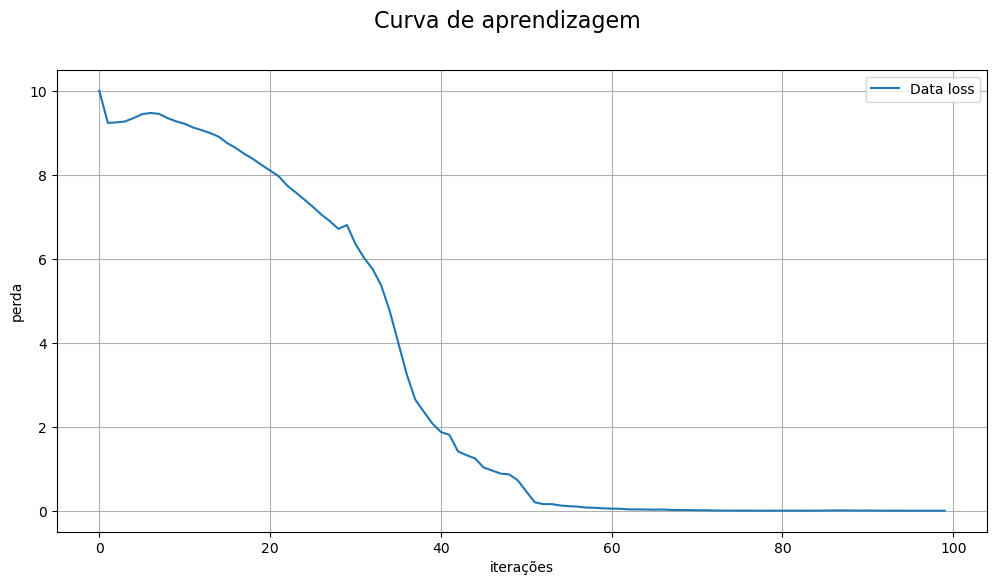

In [12]:
# Converte os dados de perda para o formato numpy, movendo-os para a CPU se necessário
loss_it = best_data_loss.cpu().numpy()

# Cria uma figura para o gráfico com tamanho personalizado
fig = plt.figure(figsize=[12, 6])

# Define o título principal da figura
fig.suptitle("Curva de aprendizagem", fontsize=16)

# Adiciona um gráfico 2D (não 3D, como foi mencionado erroneamente no comentário)
ax = fig.add_subplot(1, 1, 1)

# Definir o rótulo do eixo x
ax.set_xlabel("iterações")
# Definir o rótulo do eixo y
ax.set_ylabel("perda")

# Plota a curva de perda em função do número de iterações
ax.plot(
    range(len(loss_it)),  # No eixo x, temos o número de iterações (índices das perdas)
    loss_it,  # No eixo y, temos os valores da perda (erro) para cada iteração
    label="Data loss",  # Rótulo da linha no gráfico
)

# Adiciona uma grade no gráfico para facilitar a visualização dos pontos
ax.grid()

# Exibe a legenda, que incluirá o rótulo "Data loss"
ax.legend()

# Exibe o gráfico
plt.show()


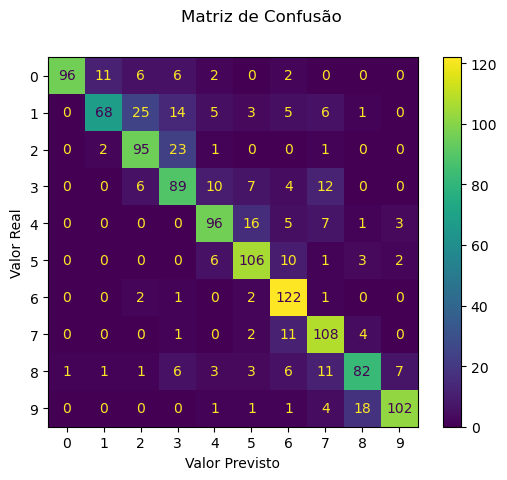

In [13]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_teste, best_pred)  
# Cria a matriz de confusão usando a função `from_predictions` da classe `ConfusionMatrixDisplay` do módulo `metrics` do Scikit-learn.
# Essa função recebe os valores reais (`y_teste`) e os valores previstos (`previsto`) para calcular e exibir a matriz de confusão.

disp.figure_.suptitle("Matriz de Confusão")  
# Define o título da figura gerada para a matriz de confusão. Aqui, o título é "Matriz de Confusão".

plt.xlabel("Valor Previsto") 
# Define o rótulo do eixo X como "Valor Previsto", representando os rótulos que foram previstos pelo modelo.

plt.ylabel("Valor Real")  
# Define o rótulo do eixo Y como "Valor Real", representando os rótulos verdadeiros dos dados de teste.

plt.show()  
# Exibe o gráfico gerado, mostrando a matriz de confusão com os rótulos dos eixos e o título definidos acima.
